In [327]:
import pandas as pd
from espn_data.get_espn_data import get_season_data
from espn_api.football import League
import toml

YEAR = 2021
secrets = toml.load(".streamlit/secrets.toml")
league = League(league_id=443750, year=YEAR, espn_s2=secrets["espn_s2"], swid=secrets["swid"])


In [328]:
league.current_week

17

In [329]:
# Iterate through the away team

def make_player_df(lineup):

    player_list = []
    for player in lineup:
        single_player = [player.playerId,
        player.name,
        player.slot_position,
        player.position,
        player.points,
        player.projected_points,
        player.proTeam
        ]
        player_list.append(single_player)

    away_points = pd.DataFrame(player_list)
    away_points.columns = ['player_id', 'player_name', 'slot_position', 'player_position', 'points', 'projected_points','pro_team']

    return away_points


def matchup_table(matchup, week, year):

    # Away team
    team1 = matchup.away_lineup
    away_points = make_player_df(team1)
    away_points['year'] = year
    away_points['week'] = week
    away_points['owner'] = matchup.away_team.owner
    away_points['fantasy_name'] = matchup.away_team.team_name
    away_points['opponent'] = matchup.home_team.owner

    # Home team
    team2 = matchup.home_lineup
    home_points = make_player_df(team2)
    home_points['year'] = year
    home_points['week'] = week
    home_points['owner'] = matchup.home_team.owner
    home_points['fantasy_name'] = matchup.home_team.team_name
    home_points['opponent'] = matchup.away_team.owner

    return (pd.concat([away_points, home_points]))

def extract_season(year):
    league = League(league_id=443750, year=year, espn_s2=secrets["espn_s2"], swid=secrets["swid"])
    full_season = []
    for i in range(1,league.current_week):
        try:
            full_week = pd.concat([matchup_table(matchup, i, league.year) for matchup in league.box_scores(i)])
            full_season.append(full_week)
        except:
            pass
    return (pd.concat(full_season))




In [331]:
compiled_seasons = []
for i in [2019, 2020, 2021, 2022]:
    full_season = extract_season(i)
    compiled_seasons.append(full_season)
    full_season.to_csv(f"/Users/tjsimons/dev/fantasy/fantasy/full_player_data/player_data_{i}.csv")
merged_complete = pd.concat(compiled_seasons)
merged_complete.to_csv("./fantasy/full_player_data/merged_full_data.csv")

In [333]:
merged_complete
# complete_data = []
# for i in [2019, 2020, 2021, 2022]:
#     complete_data.append(extract_season(i))
# merged_complete = pd.concat(complete_data).query('year < 2022')

,player_id,player_name,slot_position,player_position,points,projected_points,pro_team,year,week,owner,fantasy_name,opponent
0,16733,Odell Beckham Jr.,WR,WR,10.6,13.85,CLE,2019,1,Chris Bisbee,Elway's Teeth 49ers 16-3,James Pastrami
1,15825,Le'Veon Bell,RB,RB,20.2,14.43,NYJ,2019,1,Chris Bisbee,Elway's Teeth 49ers 16-3,James Pastrami
2,-16003,Bears D/ST,D/ST,D/ST,11.0,8.51,CHI,2019,1,Chris Bisbee,Elway's Teeth 49ers 16-3,James Pastrami
3,2976499,Amari Cooper,WR,WR,20.6,12.82,DAL,2019,1,Chris Bisbee,Elway's Teeth 49ers 16-3,James Pastrami
4,3139605,Marlon Mack,RB,RB,26.4,10.31,IND,2019,1,Chris Bisbee,Elway's Teeth 49ers 16-3,James Pastrami
...,...,...,...,...,...,...,...,...,...,...,...,...
9,-16024,Chargers D/ST,D/ST,D/ST,16.0,6.82,LAC,2022,1,Patrick Rundell,Kmet Me Bro,Raj Sreenivasan
10,16790,Jarvis Landry,BE,WR,15.9,7.32,NO,2022,1,Patrick Rundell,Kmet Me Bro,Raj Sreenivasan
11,2974858,Kenny Golladay,BE,WR,3.2,7.89,NYG,2022,1,Patrick Rundell,Kmet Me Bro,Raj Sreenivasan
12,4373626,Tyler Allgeier,BE,RB,0.0,0.00,ATL,2022,1,Patrick Rundell,Kmet Me Bro,Raj Sreenivasan


In [320]:
slot_points = merged_complete.groupby(['year', 'week',  'owner',  'opponent', 'slot_position', 'pro_team', 'player_position'], as_index=False).sum()
filtered_slots = slot_points[slot_points.year < 2022][slot_points.slot_position != "BE"][slot_points.slot_position != "IR"]

/var/folders/gg/gpf39fv57tl2v_nm98km50fc0000gn/T/ipykernel_33735/4232611136.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_slots = slot_points[slot_points.year < 2022][slot_points.slot_position != "BE"][slot_points.slot_position != "IR"]


In [322]:
merged = filtered_slots.merge(filtered_slots, how='left', left_on=['opponent', 'slot_position', 'year', 'week', 'player_position'], right_on=['owner', 'slot_position', 'year', 'week'])

ValueError: len(right_on) must equal len(left_on)

In [340]:
merged_complete.groupby(['player_name', 'owner'], as_index=False).count().sort_values('player_id', ascending=False).head(50)

,player_name,owner,player_id,slot_position,player_position,points,projected_points,pro_team,year,week,fantasy_name,opponent
455,George Kittle,Michael Sandor,45,45,45,45,45,45,45,45,45,45
870,Odell Beckham Jr.,Chris Bisbee,37,37,37,37,37,37,37,37,37,37
62,Antonio Brown,James Pastrami,30,30,30,30,30,30,30,30,30,30
6,A.J. Brown,Jon Samos,30,30,30,30,30,30,30,30,30,30
1134,Tyler Lockett,Jon Samos,30,30,30,30,30,30,30,30,30,30
13,Aaron Jones,Jon Samos,30,30,30,30,30,30,30,30,30,30
887,Patrick Mahomes,Michael Sandor,30,30,30,30,30,30,30,30,30,30
365,Deebo Samuel,Patrick Rundell,29,29,29,29,29,29,29,29,29,29
275,DJ Moore,Michael Rundell,29,29,29,29,29,29,29,29,29,29
550,Jamison Crowder,Patrick Rundell,29,29,29,29,29,29,29,29,29,29


In [309]:
merged_complete.query('year == 2021').groupby(['player_name', 'player_position'], as_index=False).mean().sort_values('points', ascending=False).head(50)

,player_name,player_position,player_id,points,projected_points,year,week,point_diff
243,Tom Brady,QB,2330.0,22.368571,20.599286,2021.0,7.5,1.769286
136,Josh Allen,QB,3918298.0,22.290000,23.035000,2021.0,7.5,-0.745000
142,Justin Herbert,QB,4038941.0,21.620000,19.655000,2021.0,7.5,1.965000
132,Jonathan Taylor,RB,4242335.0,21.314286,15.540714,2021.0,7.5,5.773571
52,Cooper Kupp,WR,2977187.0,20.492857,16.495000,2021.0,7.5,3.997857
...,...,...,...,...,...,...,...,...
10,Allen Robinson II,WR,16799.0,4.092857,7.362857,2021.0,7.5,-3.270000
30,Calvin Ridley,WR,3925357.0,3.971429,5.117143,2021.0,7.5,-1.145714
128,Jerry Jeudy,WR,4241463.0,3.892857,5.055000,2021.0,7.5,-1.162143
180,Michael Gallup,WR,4036348.0,3.778571,4.206429,2021.0,7.5,-0.427857


In [245]:
filtered_slots['point_diff'] = filtered_slots['points'] - filtered_slots['projected_points']
filtered_slots

,year,week,owner,opponent,slot_position,pro_team,player_position,player_id,points,projected_points,point_diff
6,2019,1,Chris Bisbee,James Pastrami,D/ST,CHI,D/ST,-16003,11.00,8.51,2.49
7,2019,1,Chris Bisbee,James Pastrami,QB,ATL,QB,11237,19.56,18.02,1.54
8,2019,1,Chris Bisbee,James Pastrami,RB,IND,RB,3139605,26.40,10.31,16.09
9,2019,1,Chris Bisbee,James Pastrami,RB,NYJ,RB,15825,20.20,14.43,5.77
10,2019,1,Chris Bisbee,James Pastrami,RB/WR/TE,CLE,WR,16790,9.70,9.41,0.29
...,...,...,...,...,...,...,...,...,...,...,...
7077,2021,14,Tyler Simons,Jake Verhulp,RB,TEN,RB,3126246,1.30,9.04,-7.74
7078,2021,14,Tyler Simons,Jake Verhulp,RB/WR/TE,LAC,WR,3045138,9.10,12.95,-3.85
7079,2021,14,Tyler Simons,Jake Verhulp,TE,ARI,TE,15835,6.70,6.33,0.37
7080,2021,14,Tyler Simons,Jake Verhulp,WR,KC,WR,3116406,9.60,16.36,-6.76


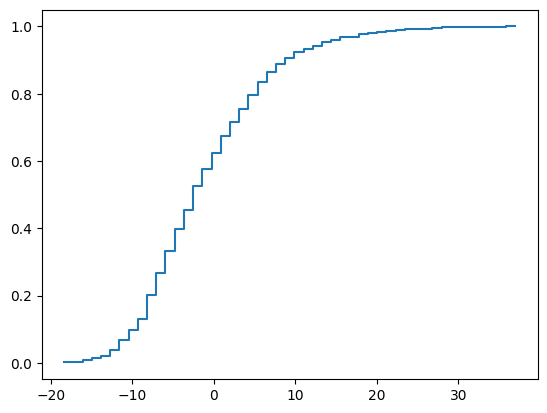

In [248]:
import numpy as np
import statsmodels.api as sm # recommended import according to the docs
import matplotlib.pyplot as plt

sample = filtered_slots.query('player_position == "RB"')['point_diff']
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)

plt.step(x, y)
plt.show()


In [161]:
import numpy as np

total_points_idx = ['year', 'week', 'owner_x']
total_points = merged.groupby(total_points_idx, as_index=False).sum()
total_points['won'] = total_points['points_x'] > total_points['points_y']

In [162]:
added_true_wins = merged.merge( total_points[total_points_idx + ["won"]]) 

In [166]:
for i in ['QB', 'RB', 'WR', 'TE', 'RB/WR/TE', 'D/ST']:
    without_qb = added_true_wins[added_true_wins.slot_position != i].groupby(total_points_idx + ['won'], as_index=False).sum()
    without_qb['without_win'] = without_qb['points_x'] > without_qb['points_y']
    change_perc = 100 * np.sum(without_qb['won'] & ~without_qb['without_win']) / without_qb.shape[0]
    print(f"{i}: {change_perc:.2f}%")

QB: 7.72%
RB: 7.11%
WR: 9.15%
TE: 5.28%
RB/WR/TE: 6.30%
D/ST: 7.52%


In [173]:
merged_complete.groupby(['slot_position', 'owner'], as_index=False).mean().sort_values('points').to_clipboard()

In [300]:
filtered_slots.groupby(['player_name'])

,year,week,owner,opponent,slot_position,pro_team,player_position,player_id,points,projected_points,point_diff
6,2019,1,Chris Bisbee,James Pastrami,D/ST,CHI,D/ST,-16003,11.00,8.51,2.49
7,2019,1,Chris Bisbee,James Pastrami,QB,ATL,QB,11237,19.56,18.02,1.54
8,2019,1,Chris Bisbee,James Pastrami,RB,IND,RB,3139605,26.40,10.31,16.09
9,2019,1,Chris Bisbee,James Pastrami,RB,NYJ,RB,15825,20.20,14.43,5.77
10,2019,1,Chris Bisbee,James Pastrami,RB/WR/TE,CLE,WR,16790,9.70,9.41,0.29
...,...,...,...,...,...,...,...,...,...,...,...
7077,2021,14,Tyler Simons,Jake Verhulp,RB,TEN,RB,3126246,1.30,9.04,-7.74
7078,2021,14,Tyler Simons,Jake Verhulp,RB/WR/TE,LAC,WR,3045138,9.10,12.95,-3.85
7079,2021,14,Tyler Simons,Jake Verhulp,TE,ARI,TE,15835,6.70,6.33,0.37
7080,2021,14,Tyler Simons,Jake Verhulp,WR,KC,WR,3116406,9.60,16.36,-6.76


In [272]:
train_x = filtered_slots.iloc[0:3000,:][['week', 'pro_team', 'player_position', 'projected_points', 'player_id']]
train_y = filtered_slots.iloc[0:3000,:]['points']
test_x = filtered_slots.iloc[3000:,:][['week', 'pro_team', 'player_position', 'projected_points', 'player_id']]
test_y = filtered_slots.iloc[3000:,:]['points']

train_x

,week,pro_team,player_position,projected_points,player_id
6,1,CHI,D/ST,8.51,-16003
7,1,ATL,QB,18.02,11237
8,1,IND,RB,10.31,3139605
9,1,NYJ,RB,14.43,15825
10,1,CLE,WR,9.41,16790
...,...,...,...,...,...
5372,5,MIN,WR,14.58,4262921
5379,5,BAL,D/ST,6.01,-16033
5381,5,LAC,QB,19.63,4038941
5382,5,NO,RB,19.81,3054850


In [297]:
# Catboosting
import numpy as np
from catboost import Pool, CatBoostRegressor
# initialize data
train_data = train_x
train_label = train_y
test_data = test_x
# initialize Pool
# train_pool = Pool(train_data, 
#                   train_label, 
#                   cat_features=[0,1,2,4])
# test_pool = Pool(test_data, 
#                  cat_features=[0,1,2,4]) 

# specify the training parameters 
model = CatBoostRegressor(iterations=200, 
                          depth=10, 
                          learning_rate=.1, 
                          loss_function='RMSE')
#train the model
model.fit(train_data, train_label, cat_features=[0,1,2,4])
# make the prediction using the resulting model
preds = model.predict(test_data)
np.sqrt(np.mean(np.square(preds - test_y)))

0:	learn: 8.6603730	total: 8.15ms	remaining: 1.62s
1:	learn: 8.4941087	total: 19.2ms	remaining: 1.9s
2:	learn: 8.3635627	total: 21.8ms	remaining: 1.43s
3:	learn: 8.2361552	total: 30.3ms	remaining: 1.48s
4:	learn: 8.1206586	total: 42.8ms	remaining: 1.67s
5:	learn: 8.0210542	total: 51.3ms	remaining: 1.66s
6:	learn: 7.9536381	total: 53.9ms	remaining: 1.49s
7:	learn: 7.8943981	total: 56.8ms	remaining: 1.36s
8:	learn: 7.8286481	total: 62.6ms	remaining: 1.33s
9:	learn: 7.7718452	total: 70.4ms	remaining: 1.34s
10:	learn: 7.7119350	total: 75.8ms	remaining: 1.3s
11:	learn: 7.6677282	total: 83.9ms	remaining: 1.31s
12:	learn: 7.6212153	total: 90.1ms	remaining: 1.3s
13:	learn: 7.5696049	total: 95.2ms	remaining: 1.26s
14:	learn: 7.5228913	total: 102ms	remaining: 1.26s
15:	learn: 7.4533338	total: 107ms	remaining: 1.23s
16:	learn: 7.4214684	total: 113ms	remaining: 1.21s
17:	learn: 7.3639638	total: 118ms	remaining: 1.19s
18:	learn: 7.3554220	total: 119ms	remaining: 1.13s
19:	learn: 7.3206224	total: 12

7.746090302066318

In [299]:
pd.DataFrame([preds, test_y])

,0,1,2,3,4,5,6,7,8,9,...,920,921,922,923,924,925,926,927,928,929
0,12.422925,10.346497,11.831455,12.57781,7.224528,20.565659,13.893647,13.693635,8.052346,8.699309,...,8.012059,11.73589,1.882571,21.109576,9.562647,8.197496,11.92489,5.737679,13.462186,10.047231
1,28.900000,10.900000,30.000000,14.20000,2.700000,39.740000,16.400000,22.200000,8.200000,8.400000,...,2.400000,0.00000,7.400000,23.480000,17.700000,1.300000,9.10000,6.700000,9.600000,23.200000
